In [1]:
import argparse
import numpy as np
from scipy.stats import norm
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn
import math
seaborn.set(color_codes=True)

In [2]:
def gaussian_funiction_single(x, mu=0 ,sigma=1):
    return math.exp(-1*(x-mu)*(x-mu)/2/sigma/sigma)/sigma/math.sqrt(2*math.pi)
        
def gaussian_funiction(x, mu=0 ,sigma=1):
    if type(x) == list:
        x = np.array(x)
    if type(x).__module__==np.__name__:
        a = np.zeros(len(x))
        for i in range(len(x)):
            a[i] = gaussian_funiction_single(x[i],mu,sigma)
        return a
    else :
        return gaussian_funiction_single(x, mu, sigma)

print(norm.pdf(5, loc=1, scale=1))
print(gaussian_funiction(5,1,1))
print(gaussian_funiction([1, 5], 1, 1))

seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)

0.000133830225765
0.00013383022576488537
[  3.98942280e-01   1.33830226e-04]


In [3]:
class DataDistribution(object):
    '''
        The distribution of real data
    '''
    def __init__(self, mu = 2, sigma = 0.5):
        self.mu = mu
        self.sigma = sigma
        
    def sample(self, N):
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort() #sort the elements in samples
        return samples

class GeneratorDistribution(object):
    def __init__(self, range):
        self.range = range

    def sample(self, N):
        samples = np.random.uniform(low = -self.range, high = self.range, size= N)
        samples.sort()
        return samples

def linear(input, output_dim, scope=None, stddev=1.0):
    '''
    operation :
        input :
            matrixes(a*b)
        input.get_shape() => (a, b)
        input.get_shape()[1] => b
        w => b*output_dim
        tf.matmul(input, w ) => a * output_dim
        b= > output_dim
    return :
        matrixes(a*output_dim) 
    '''
    norm = tf.random_normal_initializer(stddev=stddev)
    const = tf.constant_initializer(0.0)
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('weights', [input.get_shape()[1], output_dim], initializer=norm)
        b = tf.get_variable('biases', [output_dim], initializer=const)
        return tf.matmul(input, w) + b

def generator(input, h_dim):
    '''
    input : a*b
            a*h_dim
            activation(a*h_dim) => a* h_dim
            a*1 
    return : 
        matrixes(a*1)
    '''
    h0 = tf.tanh(linear(input, h_dim, 'g0'))
    h1 = tf.tanh(linear(h0, h_dim, 'g1'))
    h2 = linear(h1, 1, 'g2')
    return h2

def discriminator(input, h_dim):
    '''
    input :
        a*1
        a*(h_dim*2)
        a*(h_dim*2)
    '''
    h0 = tf.tanh(linear(input, 2*h_dim , scope = 'd0'))
    h1 = tf.tanh(linear(h0, 2*h_dim, scope = 'd1'))
    h2 = linear(h1, 1, scope='d2')
    return h2

def clip_op(clip, var_list):
    step = tf.Variable(0.0, name = "step")
    count = tf.assign(step, step + 1)
    for var in var_list:
        new_var = tf.clip_by_value(var
                                , clip_value_max = clip
                                , clip_value_min = -clip)
        count = tf.group(count, tf.assign(var, new_var))
    return count

def optimizer(loss, var_list, initial_learning_rate):
    decay = 0.95
    num_decay_steps = 150
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        initial_learning_rate,
        batch,
        num_decay_steps,
        decay,
        staircase=True
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss,
        global_step = batch,
        var_list = var_list
    )
    return optimizer

def print_keys(string):
    i=0
    while True:
        try:
            print(tf.get_collection(string)[i].op.name)
            i+=1
        except IndexError:
            break

0: 	 error0.08202281594276428


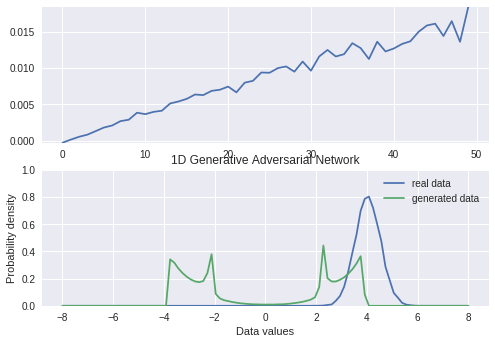

10: 	 error0.26604318618774414


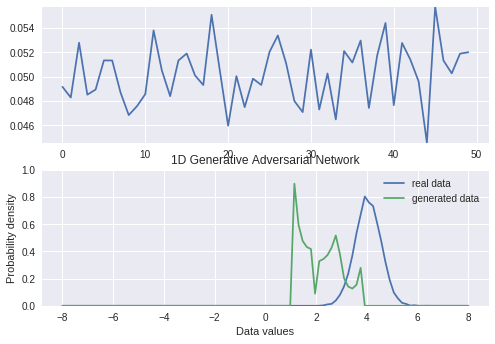

20: 	 error0.0


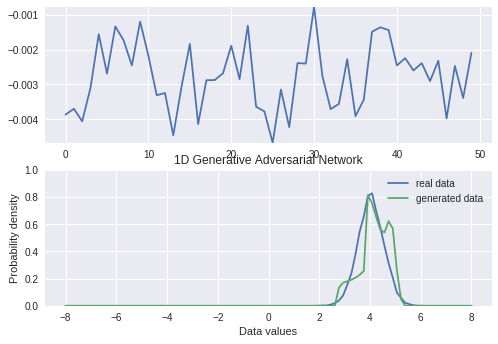

30: 	 error0.0


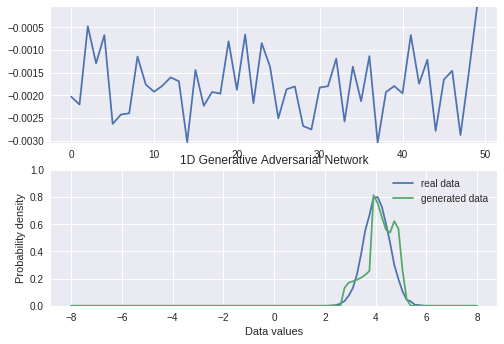

In [4]:
class GAN(object):
    def __init__(self, data, gen, num_steps, sub_steps, batch_size, log_every):
        self.data = data
        self.gen = gen
        self.num_steps = num_steps
        self.sub_steps = sub_steps
        self.batch_size = batch_size
        self.log_every = log_every
        self.mlp_hidden_size = 10
        self.learning_rate = 0.01
        self._create_model()

    def _create_model(self):        
        with tf.variable_scope('Gen'):
            self.z = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.G = generator(self.z, self.mlp_hidden_size)

        with tf.variable_scope('Disc') as scope:
            self.x = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.D1 = discriminator(self.x, self.mlp_hidden_size)
            scope.reuse_variables()
            self.D2 = discriminator(self.G, self.mlp_hidden_size)
            
        #print_keys("trainable_variables")
        self.loss_d = tf.reduce_mean(self.D1 - self.D2)
        self.loss_g = tf.nn.relu(tf.multiply(5.0, self.loss_d))
        self.d_params = tf.get_collection("trainable_variables", scope='Disc')
        self.g_params = tf.get_collection("trainable_variables", scope='Gen')

        self.opt_d = optimizer(-self.loss_d, self.d_params, self.learning_rate)
        self.clip_d = clip_op(0.05, self.d_params)
        self.opt_g = optimizer(self.loss_g, self.g_params, 10*self.learning_rate)

    def train(self):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for step in range(self.num_steps):
                
                self.loss_d_tract = []
                for sub_step in range(self.sub_steps):
                    x = self.data.sample(self.batch_size) # sample from original data
                    z = self.gen.sample(self.batch_size) # sample from random
                    sess.run(self.opt_d, feed_dict = 
                        {
                        self.x : np.reshape(x, (self.batch_size, 1)),
                        self.z : np.reshape(z, (self.batch_size, 1))
                        }
                    )
                    sess.run(self.clip_d)
                    self.loss_d_tract.append(sess.run(self.loss_d, feed_dict =  
                        {
                        self.x : np.reshape(x, (self.batch_size, 1)),
                        self.z : np.reshape(z, (self.batch_size, 1))
                        }))
                
                # update generator
                x = self.data.sample(self.batch_size)
                z = self.gen.sample(self.batch_size)
                loss_g, _ = sess.run([self.loss_g, self.opt_g], feed_dict = {
                        self.x : np.reshape(x, (self.batch_size, 1)),
                        self.z : np.reshape(z, (self.batch_size, 1))
                    }
                )

                if step % self.log_every == 0:
                    print('{}: \t error{}'.format(step, loss_g))                 
                    self._plot_distributions(sess)
                    
    def _samples(self, sess, num_points=10000, num_bins=100):
        '''
        Return a tuple (db, pd, pg), where db is the current decision
        boundary, pd is a histogram of samples from the data distribution,
        and pg is a histogram of generated samples.
        '''
        xs = np.linspace(-self.gen.range, self.gen.range, num_points)
        bins = np.linspace(-self.gen.range, self.gen.range, num_bins)

        # data distribution
        d = self.data.sample(num_points)
        pd, _ = np.histogram(d, bins=bins, density=True)

        # generated samples
        zs = np.linspace(-self.gen.range, self.gen.range, num_points)
        g = np.zeros((num_points, 1))
        for i in range(num_points // self.batch_size):
            g[self.batch_size * i:self.batch_size * (i + 1)] = sess.run(self.G, {
                self.z: np.reshape(
                    zs[self.batch_size * i:self.batch_size * (i + 1)],
                    (self.batch_size, 1)
                )
            })
        pg, _ = np.histogram(g, bins=bins, density=True)

        return pd, pg

    def _plot_distributions(self, sess):
        fig = plt.figure()
        ax1 = fig.add_subplot(2, 1, 1)
        ax2 = fig.add_subplot(2, 1, 2)
        ax1.set_ylim(np.min(np.array(self.loss_d_tract)), np.max(np.array(self.loss_d_tract)))
        ax2.set_ylim(0, 1)            
        ax1.plot(self.loss_d_tract)            
        pd, pg = self._samples(sess)
        p_x = np.linspace(-self.gen.range, self.gen.range, len(pd))
        ax2.plot(p_x, pd, label='real data')
        ax2.plot(p_x, pg, label='generated data')
        ax2.set_title('1D Generative Adversarial Network')
        ax2.set_xlabel('Data values')
        ax2.set_ylabel('Probability density')
        ax2.legend()
        plt.show()

model = GAN(
    data = DataDistribution(mu = 4, sigma = 0.5),#data
    gen = GeneratorDistribution(range = 8), #gen
    num_steps = 31,
    sub_steps = 50,
    batch_size = 200,
    log_every = 10
)
model.train()